## Using PyTorch to implement Softmax Regression to classify handwritten digit images.

## Softmax Regression

In [7]:
import torch # PyTorch
from torch.utils.data import DataLoader
import torchvision.datasets as datasets # Some well-known datasets
import torchvision.transforms as transforms # Image data transformation
import matplotlib.pyplot as plt

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
train_dataset = datasets.MNIST(root='/content/mnist', train=True,
                              transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='/content/mnist', train=False,
                              transform=transforms.ToTensor(), download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /content/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /content/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/mnist/MNIST/raw



4


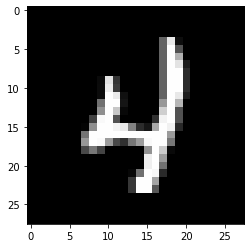

In [8]:
image, label = train_dataset[217]
print(label)
plt.imshow(image.squeeze(), cmap='gray')

In [9]:
# Hyperparameters
input_size = 28*28 # 784
num_classes = 10 # 10 digits 0, 1, 2, ..., 9
learning_rate = 0.001
num_epochs = 5
batch_size = 64

In [10]:
# Create a DataLoader to help Pytorch load the data efficiently
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
# Build a Softmax Regression model
class SoftmaxRegression(torch.nn.Module):
    def __init__(self, input_size, num_classes):
        super(SoftmaxRegression, self).__init__() # Python syntax
        self.layer = torch.nn.Linear(in_features=input_size, out_features=num_classes)

    def forward(self, x):
        out = self.layer(x) # z_scores
        #out = torch.sigmoid(out) # Logistic Regression: 2 classes. NEED!!!
        #out = torch.softmax(out)  # Softmax Regression: >= 2 classes. NO NEED!!!

        return out

In [13]:
# Create and initialize a model
model = SoftmaxRegression(input_size, num_classes).to(device)

In [14]:
# Declare the loss function and optimization algorithm
criterion = torch.nn.BCELoss() # Binary Cross Entropy Loss for Logistic Regression: NLL(a,y)
criterion = torch.nn.CrossEntropyLoss() # Softmax Regression: Softmax(z) + NLL

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # Stochastic Gradient Descent

In [15]:
# Train our model\n",
for epoch in range(num_epochs):
    for batch_idx, (images, labels) in enumerate(train_loader):
        # Put the images and labels to GPU if available
        images = images.to(device)
        labels = labels.to(device)

        # Reshape the data
        # 'images' is a batch of 64 images, and each image has the shape of (1,28,28)
        # But our model requires the input size of 784.
        # We need to transform (1,28,28) ---> 784.
        # images.shape[0] ---> 64. We can keep this dimension.
        images = images.reshape(images.shape[0], -1) # (64,1,28,28) --> (64, 784)

        # forward pass
        z_scores = model(images) # We pass 64 images through the model at a time 
        # z_scores has the shape of (64, 10)

        loss = criterion(z_scores, labels)

        # backward pass
        optimizer.zero_grad()   # empty the memory
        loss.backward()         # compute gradients
        optimizer.step()        # perform one step of gradient descent

        if (batch_idx+1)%100 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}, Loss: {loss.item():.2f}')

Epoch 1/5, Batch 100, Loss: 2.26
Epoch 1/5, Batch 200, Loss: 2.11
Epoch 1/5, Batch 300, Loss: 2.04
Epoch 1/5, Batch 400, Loss: 1.96
Epoch 1/5, Batch 500, Loss: 1.85
Epoch 1/5, Batch 600, Loss: 1.79
Epoch 1/5, Batch 700, Loss: 1.69
Epoch 1/5, Batch 800, Loss: 1.73
Epoch 1/5, Batch 900, Loss: 1.71
Epoch 2/5, Batch 100, Loss: 1.51
Epoch 2/5, Batch 200, Loss: 1.49
Epoch 2/5, Batch 300, Loss: 1.43
Epoch 2/5, Batch 400, Loss: 1.47
Epoch 2/5, Batch 500, Loss: 1.39
Epoch 2/5, Batch 600, Loss: 1.37
Epoch 2/5, Batch 700, Loss: 1.41
Epoch 2/5, Batch 800, Loss: 1.31
Epoch 2/5, Batch 900, Loss: 1.23
Epoch 3/5, Batch 100, Loss: 1.26
Epoch 3/5, Batch 200, Loss: 1.26
Epoch 3/5, Batch 300, Loss: 1.15
Epoch 3/5, Batch 400, Loss: 1.10
Epoch 3/5, Batch 500, Loss: 1.15
Epoch 3/5, Batch 600, Loss: 1.09
Epoch 3/5, Batch 700, Loss: 1.03
Epoch 3/5, Batch 800, Loss: 0.94
Epoch 3/5, Batch 900, Loss: 1.00
Epoch 4/5, Batch 100, Loss: 0.93
Epoch 4/5, Batch 200, Loss: 1.09
Epoch 4/5, Batch 300, Loss: 1.02
Epoch 4/5,

In [16]:
# Evaluate the accuracy of our trained model on the test dataset
def check_accuracy(loader, model):
    num_corrects = 0
    num_samples = 0

    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            images = images.reshape(images.shape[0], -1)

            # forward pass
            z_scores = model(images) # 64 images at a time
            # z_scores has the shape (64, 10)
            _, predictions = z_scores.max(1) # 0 ~ rows, 1 ~ columns

            num_corrects += (predictions == labels).sum()
            num_samples += (predictions.size(0))

        print(f'We get {num_corrects}/{num_samples} correct.')
        print(f'Accuracy {float(num_corrects)/float(num_samples)*100.0:.2f}')

In [17]:
check_accuracy(test_loader, model)

We get 8458/10000 correct.
Accuracy 84.58


5


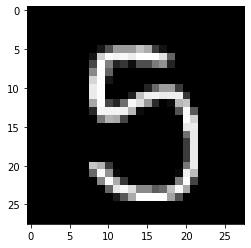

In [18]:
# Check some images
image, label = test_dataset[3756]
print(label)
plt.imshow(image.squeeze(), cmap='gray')

In [19]:
image = image.to(device)
image = image.reshape(image.shape[0], -1) # (1,28,28) ---> (1, 784)
z_score = model(image)
print(z_score)
_, prediction = z_score.max(1)
print(f'Our prediction is {prediction.item()}')

tensor([[ 0.5573, -0.8438, -0.2955,  1.4530, -0.6805,  0.9336, -0.8378, -0.6587,
          1.0031, -0.3868]], grad_fn=<AddmmBackward0>)
Our prediction is 3
